In [29]:
#import the necessary libraries
from os import listdir
from os.path import isfile, join
from skimage.transform import resize
import numpy as np
import cv2 as cv
import pandas as pd
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
from skimage.io import imread, imshow
from skimage.feature import hog
from skimage import exposure
import csv
# from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

%matplotlib inline


In [30]:
#path where images are located
mypath='UFPR-Periocular/periocularCropped/'
#Reading files of images from folder path
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
images = np.empty(len(onlyfiles), dtype=object)

(256, 256, 3)
(128, 64, 3)


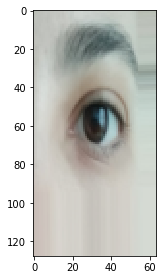

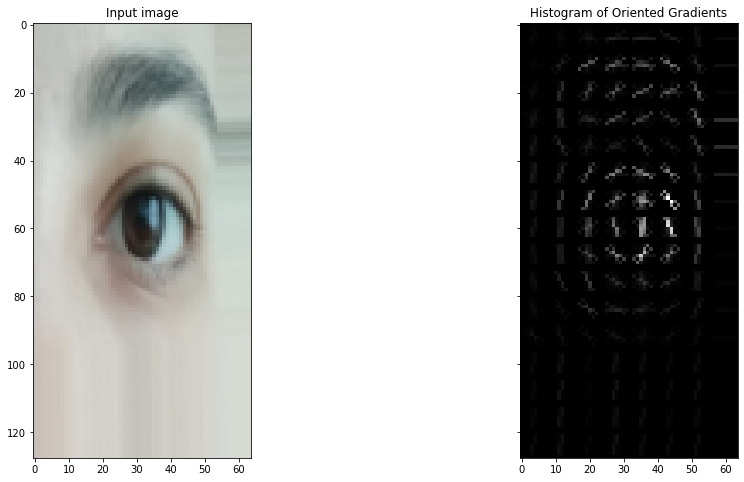

(256, 256, 3)
(128, 64, 3)


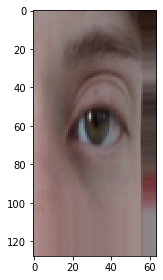

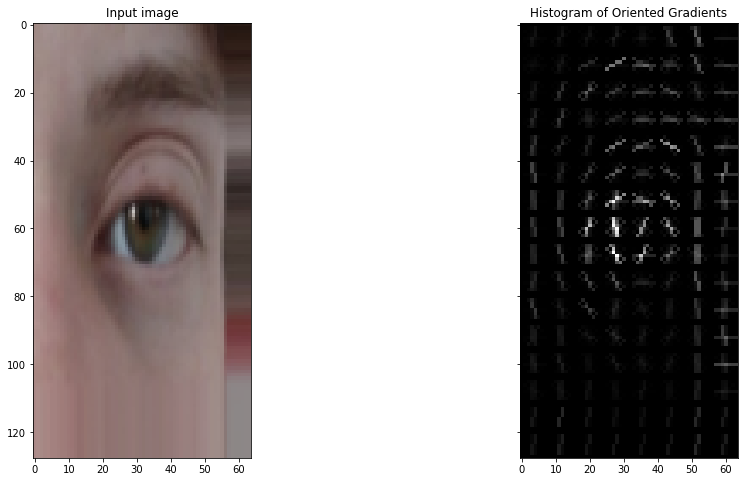

(256, 256, 3)
(128, 64, 3)


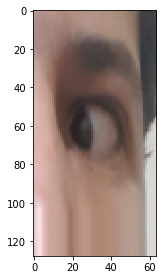

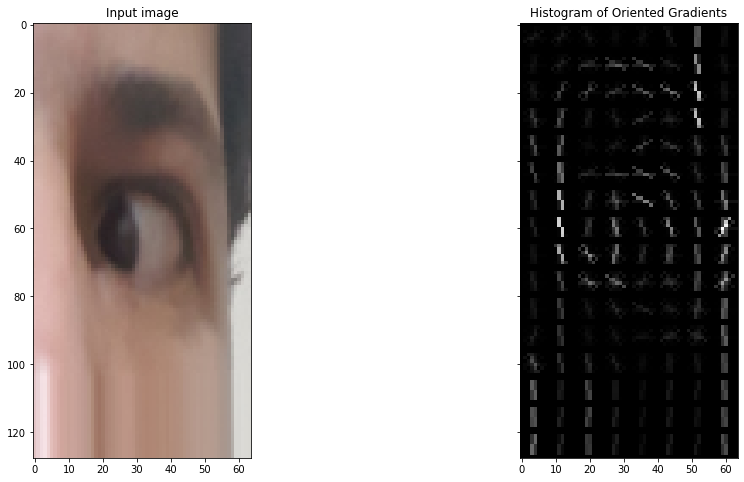

(256, 256, 3)
(128, 64, 3)


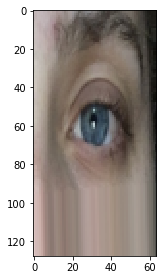

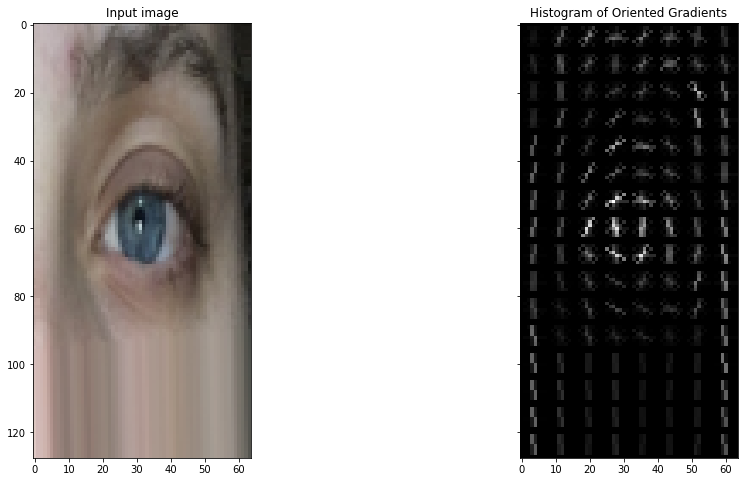

(256, 256, 3)
(128, 64, 3)


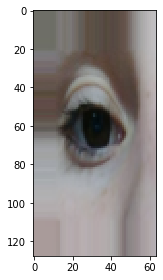

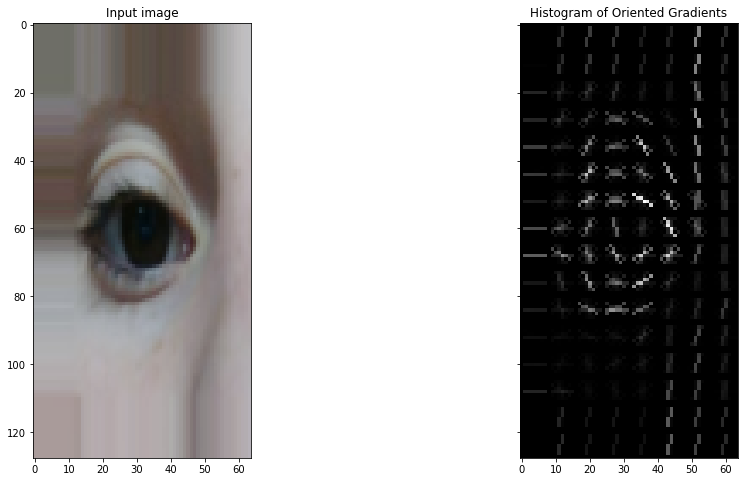

In [31]:
labels = []
images_modified = []

for n in range(0, 5):
    images[n] = cv.imread( join(mypath,onlyfiles[n]) )
    img = cv.cvtColor(images[n] ,cv.COLOR_BGR2RGB)
    
    print(img.shape)
    
    #resizing image 
    resized_img = resize(img, (128,64)) 
    imshow(resized_img) 
    print(resized_img.shape)
    
    #creating hog features 
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), 
                        cells_per_block=(2, 2), visualize=True, multichannel=True)

    images_modified.append(hog_image)
    labels.append(mypath)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 

    ax1.imshow(resized_img, cmap=plt.cm.gray) 
    ax1.set_title('Input image') 

    # Rescale histogram for better display 
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) 

    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
    ax2.set_title('Histogram of Oriented Gradients')

    plt.show()
       

In [8]:
import csv
from collections import defaultdict
from sklearn.model_selection import train_test_split

mypath='UFPR-Periocular/periocularCropped/'
columns = defaultdict(list)
age_label = []
gender_label = []
hog_images = []
hog_features = []

with open('UFPR-Periocular/imagesInfo_csv.csv', mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    df = pd.read_csv(csv_file)
    image_file_name,age,gender = df.file_name,df.age,df.gender

    
    for i in range(1000):
        image = cv.imread( join(mypath,image_file_name[i]) )
        img = cv.cvtColor(image ,cv.COLOR_RGB2BGR)
        resized_img = resize(img, (128,64)) 
        fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), 
                        cells_per_block=(2, 2), visualize=True, multichannel=True)

        hog_images.append(hog_image)
        hog_features.append(fd)
        age_label.append(age[i])
        gender_label.append(gender[i])
        
    #Fit a SVM classifier to the data
    age_labels =  np.array(age_label)
    gender_labels =  np.array(gender_label)
    X = np.array(hog_features)
    #data_frame = np.hstack((hog_features,labels))
    #np.random.shuffle(data_frame)

    # Combine training labels
    #y = np.vstack((age_labels, gender_labels)).T
    y = np.array(gender_labels)
    
    # Split into training and testing data
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    clf = svm.SVC().fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    
    print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
    #print('\n')
    print(classification_report(y_test, y_pred))
    
    C = 1.0
    
    #Non-Linear RBF
    rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C)
    rbf_svc.fit(x_train,y_train)
    y_pred = rbf_svc.predict(x_test)
    
    print("Non-Linear RBF Accuracy: "+str(accuracy_score(y_test, y_pred)))
    #print('\n')
    print(classification_report(y_test, y_pred))
    
    #Non-Linear Ploy
    poly_svc = svm.SVC(kernel='poly', degree=3, C=C)
    poly_svc.fit(x_train,y_train)
    y_pred = poly_svc.predict(x_test)
    
    print("Non-Linear Poly Accuracy: "+str(accuracy_score(y_test, y_pred)))
    #print('\n')
    print(classification_report(y_test, y_pred))

Accuracy: 0.9787878787878788
              precision    recall  f1-score   support

      female       0.99      0.92      0.95        74
        male       0.98      1.00      0.99       256

    accuracy                           0.98       330
   macro avg       0.98      0.96      0.97       330
weighted avg       0.98      0.98      0.98       330

Non-Linear RBF Accuracy: 0.7757575757575758
              precision    recall  f1-score   support

      female       0.00      0.00      0.00        74
        male       0.78      1.00      0.87       256

    accuracy                           0.78       330
   macro avg       0.39      0.50      0.44       330
weighted avg       0.60      0.78      0.68       330



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Non-Linear Poly Accuracy: 0.9939393939393939
              precision    recall  f1-score   support

      female       0.99      0.99      0.99        74
        male       1.00      1.00      1.00       256

    accuracy                           0.99       330
   macro avg       0.99      0.99      0.99       330
weighted avg       0.99      0.99      0.99       330



In [9]:
with open('UFPR-Periocular/imagesInfo_csv.csv', mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    df = pd.read_csv(csv_file)
    image_file_name,age,gender = df.file_name,df.age,df.gender
    age_groups = pd.cut(df['age'], bins=[0,9,19,29,39,49,59,69,79,89,99])
    df.groupby(age_groups)
    print(pd.crosstab(age_groups, df['gender']))

gender    female  male
age                   
(9, 19]     3870  4350
(19, 29]    5760  7590
(29, 39]    1530  2580
(39, 49]    2070  1890
(49, 59]    1590  1170
(59, 69]     420   450
(69, 79]     360    30


In [32]:
import csv
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split

mypath='UFPR-Periocular/periocularCropped/'
columns = defaultdict(list)
age_label = []
female_age_label = []
age_labels = []
gender_label = []
hog_images = []
hog_features = []
female_hog_features = []


with open('UFPR-Periocular/imagesInfo_csv.csv', mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    df = pd.read_csv(csv_file)
    image_file_name,age,gender = df.file_name,df.age,df.gender

    
    for i in range(len(image_file_name)):
        image = cv.imread( join(mypath,image_file_name[i]) )
        img = cv.cvtColor(image ,cv.COLOR_RGB2BGR)
        resized_img = resize(img, (128,64)) 
        fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), 
                        cells_per_block=(2, 2), visualize=True, multichannel=True)

        hog_images.append(hog_image)
        if gender[i]== 'male':
            hog_features.append(fd)
            if age[i]<10:
                age_label.append("0-9")
            elif age[i]<20:
                age_label.append("10-19")
            elif age[i]<30:
                age_label.append("20-29")
            elif age[i]<40:
                age_label.append("30-39")
            elif age[i]<50:
                age_label.append("40-49")
            elif age[i]<60:
                age_label.append("50-59")
            elif age[i]<70:
                age_label.append("60-69")
            elif age[i]<80:
                age_label.append("70-79")
            elif age[i]<90:
                age_label.append("80-89")
            elif age[i]<100:
                age_label.append("90-99")
        else:
            female_hog_features.append(fd)
            if age[i]<10:
                female_age_label.append("0-9")
            elif age[i]<20:
                female_age_label.append("10-19")
            elif age[i]<30:
                female_age_label.append("20-29")
            elif age[i]<40:
                female_age_label.append("30-39")
            elif age[i]<50:
                female_age_label.append("40-49")
            elif age[i]<60:
                female_age_label.append("50-59")
            elif age[i]<70:
                female_age_label.append("60-69")
            elif age[i]<80:
                female_age_label.append("70-79")
            elif age[i]<90:
                female_age_label.append("80-89")
            elif age[i]<100:
                female_age_label.append("90-99")
                            
    #Fit a SVM classifier to the data
    y =  np.array(age_label)
    gender_labels =  np.array(gender_label)
    X = np.array(hog_features)
    #data_frame = np.hstack((hog_features,labels)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    clf = svm.SVC().fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    
    print("MALE")
    print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
    #print('\n')
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print("Accuracy for each class")
    print(cm.diagonal()/cm.sum(axis=1))
    print('\n')
    print('\n')
    C = 1.0
    
    #Non-Linear RBF
    rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C)
    rbf_svc.fit(x_train,y_train)
    y_pred = rbf_svc.predict(x_test)
    
    print("Non-Linear RBF Accuracy: "+str(accuracy_score(y_test, y_pred)))
    #print('\n')
    print(classification_report(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print("Accuracy for each class")
    print(cm.diagonal()/cm.sum(axis=1))
    print('\n')
    print('\n')
    
    #Non-Linear Ploy
    poly_svc = svm.SVC(kernel='poly', degree=3, C=C)
    poly_svc.fit(x_train,y_train)
    y_pred = poly_svc.predict(x_test)
    print("Non-Linear Poly Accuracy: "+str(accuracy_score(y_test, y_pred)))
    #print('\n')
    print(classification_report(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print("Accuracy for each class")
    print(cm.diagonal()/cm.sum(axis=1))
    print('\n')
    print('\n')
    
    #MLP Classifier
    mlp_clf = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001,
                     solver='sgd', verbose=10,  random_state=21,tol=0.000000001)
    mlp_clf.fit(x_train, y_train)
    y_pred = mlp_clf.predict(x_test)
    print("MLP Accuracy: "+str(accuracy_score(y_test, y_pred)))
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print("Accuracy for each class")
    print(cm.diagonal()/cm.sum(axis=1))
    print('\n')
    print('\n')

MALE
Accuracy: 0.7385906040268456
              precision    recall  f1-score   support

       10-19       0.81      0.58      0.68      1451
       20-29       0.67      0.92      0.78      2467
       30-39       0.83      0.52      0.64       882
       40-49       0.83      0.66      0.73       621
       50-59       0.81      0.74      0.77       379
       60-69       0.98      0.84      0.90       152
       70-79       1.00      0.88      0.93         8

    accuracy                           0.74      5960
   macro avg       0.85      0.73      0.78      5960
weighted avg       0.76      0.74      0.73      5960

Accuracy for each class
[0.58373535 0.92217268 0.51927438 0.65861514 0.73614776 0.83552632
 0.875     ]




Non-Linear RBF Accuracy: 0.4139261744966443
              precision    recall  f1-score   support

       10-19       0.00      0.00      0.00      1451
       20-29       0.41      1.00      0.59      2467
       30-39       0.00      0.00      0.00       882


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Non-Linear Poly Accuracy: 0.8536912751677852
              precision    recall  f1-score   support

       10-19       0.85      0.81      0.83      1451
       20-29       0.84      0.90      0.87      2467
       30-39       0.87      0.78      0.83       882
       40-49       0.87      0.83      0.85       621
       50-59       0.87      0.88      0.88       379
       60-69       0.97      0.93      0.95       152
       70-79       1.00      1.00      1.00         8

    accuracy                           0.85      5960
   macro avg       0.90      0.88      0.89      5960
weighted avg       0.85      0.85      0.85      5960

              precision    recall  f1-score   support

       10-19       0.85      0.81      0.83      1451
       20-29       0.84      0.90      0.87      2467
       30-39       0.87      0.78      0.83       882
       40-49       0.87      0.83      0.85       621
       50-59       0.87      0.88      0.88       379
       60-69       0.97      0.93

Iteration 212, loss = 0.03592037
Iteration 213, loss = 0.03518919
Iteration 214, loss = 0.03427757
Iteration 215, loss = 0.03380548
Iteration 216, loss = 0.03279700
Iteration 217, loss = 0.03230946
Iteration 218, loss = 0.03153240
Iteration 219, loss = 0.03101707
Iteration 220, loss = 0.03035057
Iteration 221, loss = 0.02988581
Iteration 222, loss = 0.02917651
Iteration 223, loss = 0.02838855
Iteration 224, loss = 0.02803602
Iteration 225, loss = 0.02739342
Iteration 226, loss = 0.02692832
Iteration 227, loss = 0.02657342
Iteration 228, loss = 0.02593101
Iteration 229, loss = 0.02554585
Iteration 230, loss = 0.02504130
Iteration 231, loss = 0.02452261
Iteration 232, loss = 0.02411410
Iteration 233, loss = 0.02378130
Iteration 234, loss = 0.02331944
Iteration 235, loss = 0.02288399
Iteration 236, loss = 0.02240294
Iteration 237, loss = 0.02206110
Iteration 238, loss = 0.02168765
Iteration 239, loss = 0.02129748
Iteration 240, loss = 0.02092078
Iteration 241, loss = 0.02064946
Iteration 

Iteration 461, loss = 0.00315937
Iteration 462, loss = 0.00314674
Iteration 463, loss = 0.00313149
Iteration 464, loss = 0.00311277
Iteration 465, loss = 0.00310311
Iteration 466, loss = 0.00308507
Iteration 467, loss = 0.00307776
Iteration 468, loss = 0.00304912
Iteration 469, loss = 0.00304256
Iteration 470, loss = 0.00303397
Iteration 471, loss = 0.00301086
Iteration 472, loss = 0.00300092
Iteration 473, loss = 0.00299524
Iteration 474, loss = 0.00297896
Iteration 475, loss = 0.00296205
Iteration 476, loss = 0.00295518
Iteration 477, loss = 0.00294149
Iteration 478, loss = 0.00292945
Iteration 479, loss = 0.00291725
Iteration 480, loss = 0.00289848
Iteration 481, loss = 0.00288626
Iteration 482, loss = 0.00287346
Iteration 483, loss = 0.00286517
Iteration 484, loss = 0.00286161
Iteration 485, loss = 0.00283972
Iteration 486, loss = 0.00282431
Iteration 487, loss = 0.00281187
Iteration 488, loss = 0.00280722
Iteration 489, loss = 0.00279693
Iteration 490, loss = 0.00278569
Iteration 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [33]:
y =  np.array(female_age_label)
X = np.array(female_hog_features)   
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = svm.SVC().fit(x_train,y_train)
y_pred = clf.predict(x_test)

print("FEMALE")
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
#print('\n')
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Accuracy for each class")
print(cm.diagonal()/cm.sum(axis=1))
print('\n')
print('\n')
C = 1.0
    
#Non-Linear RBF
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C)
rbf_svc.fit(x_train,y_train)
y_pred = rbf_svc.predict(x_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Accuracy for each class")
print(cm.diagonal()/cm.sum(axis=1))
print('\n')
print('\n')
    
print("Non-Linear RBF Accuracy: "+str(accuracy_score(y_test, y_pred)))
#print('\n')
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Accuracy for each class")
print(cm.diagonal()/cm.sum(axis=1))
print('\n')
print('\n')   
#Non-Linear Ploy
poly_svc = svm.SVC(kernel='poly', degree=3, C=C)
poly_svc.fit(x_train,y_train)
y_pred = poly_svc.predict(x_test)
    
print("Non-Linear Poly Accuracy: "+str(accuracy_score(y_test, y_pred)))
#print('\n')
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Accuracy for each class")
print(cm.diagonal()/cm.sum(axis=1))
print('\n')
print('\n')

#MLP Classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001,
                     solver='sgd', verbose=10,  random_state=21,tol=0.000000001)
mlp_clf.fit(x_train, y_train)
y_pred = mlp_clf.predict(x_test)
    
print("MLP Accuracy: "+str(accuracy_score(y_test, y_pred)))
#print('\n')
print(classification_report(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Accuracy for each class")
print(cm.diagonal()/cm.sum(axis=1))
print('\n')
print('\n')


FEMALE
Accuracy: 0.7558275058275058
              precision    recall  f1-score   support

       10-19       0.80      0.68      0.73      1251
       20-29       0.70      0.90      0.78      1910
       30-39       0.89      0.42      0.57       505
       40-49       0.79      0.74      0.77       709
       50-59       0.78      0.81      0.80       520
       60-69       1.00      0.53      0.70       146
       70-79       0.90      0.84      0.87       107

    accuracy                           0.76      5148
   macro avg       0.84      0.70      0.75      5148
weighted avg       0.77      0.76      0.75      5148

Accuracy for each class
[0.67705835 0.89790576 0.41980198 0.74330042 0.81153846 0.53424658
 0.8411215 ]






/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       10-19       0.00      0.00      0.00      1251
       20-29       0.37      1.00      0.54      1910
       30-39       0.00      0.00      0.00       505
       40-49       0.00      0.00      0.00       709
       50-59       0.00      0.00      0.00       520
       60-69       0.00      0.00      0.00       146
       70-79       0.00      0.00      0.00       107

    accuracy                           0.37      5148
   macro avg       0.05      0.14      0.08      5148
weighted avg       0.14      0.37      0.20      5148

Accuracy for each class
[0. 1. 0. 0. 0. 0. 0.]




Non-Linear RBF Accuracy: 0.37101787101787104
              precision    recall  f1-score   support

       10-19       0.00      0.00      0.00      1251
       20-29       0.37      1.00      0.54      1910
       30-39       0.00      0.00      0.00       505
       40-49       0.00      0.00      0.00       709
       50-59       0.00      0.00   

Iteration 190, loss = 0.08783503
Iteration 191, loss = 0.08335046
Iteration 192, loss = 0.08191243
Iteration 193, loss = 0.07969112
Iteration 194, loss = 0.07733552
Iteration 195, loss = 0.07481294
Iteration 196, loss = 0.07265116
Iteration 197, loss = 0.07028634
Iteration 198, loss = 0.07038534
Iteration 199, loss = 0.06755928
Iteration 200, loss = 0.06587014
Iteration 201, loss = 0.06490641
Iteration 202, loss = 0.06253350
Iteration 203, loss = 0.06063458
Iteration 204, loss = 0.05974121
Iteration 205, loss = 0.05850285
Iteration 206, loss = 0.05664788
Iteration 207, loss = 0.05512870
Iteration 208, loss = 0.05417340
Iteration 209, loss = 0.05314460
Iteration 210, loss = 0.05224193
Iteration 211, loss = 0.05057296
Iteration 212, loss = 0.04905737
Iteration 213, loss = 0.04875325
Iteration 214, loss = 0.04686966
Iteration 215, loss = 0.04665855
Iteration 216, loss = 0.04518974
Iteration 217, loss = 0.04427654
Iteration 218, loss = 0.04359108
Iteration 219, loss = 0.04257348
Iteration 

Iteration 439, loss = 0.00443896
Iteration 440, loss = 0.00440197
Iteration 441, loss = 0.00437996
Iteration 442, loss = 0.00435897
Iteration 443, loss = 0.00433359
Iteration 444, loss = 0.00431329
Iteration 445, loss = 0.00429617
Iteration 446, loss = 0.00426743
Iteration 447, loss = 0.00424647
Iteration 448, loss = 0.00422772
Iteration 449, loss = 0.00421049
Iteration 450, loss = 0.00418664
Iteration 451, loss = 0.00417751
Iteration 452, loss = 0.00415011
Iteration 453, loss = 0.00412785
Iteration 454, loss = 0.00410321
Iteration 455, loss = 0.00408027
Iteration 456, loss = 0.00406461
Iteration 457, loss = 0.00404680
Iteration 458, loss = 0.00403352
Iteration 459, loss = 0.00400695
Iteration 460, loss = 0.00399003
Iteration 461, loss = 0.00397778
Iteration 462, loss = 0.00393854
Iteration 463, loss = 0.00394020
Iteration 464, loss = 0.00392055
Iteration 465, loss = 0.00389135
Iteration 466, loss = 0.00387829
Iteration 467, loss = 0.00386024
Iteration 468, loss = 0.00384136
Iteration 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [34]:
import csv
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

mypath='UFPR-Periocular/periocularCropped/'
columns = defaultdict(list)
age_label = []
female_age_label = []
age_labels = []
gender_label = []
hog_images = []
hog_features = []
female_hog_features = []


with open('UFPR-Periocular/imagesInfo_csv.csv', mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    df = pd.read_csv(csv_file)
    image_file_name,age,gender = df.file_name,df.age,df.gender

    
    for i in range(1000):
        image = cv.imread( join(mypath,image_file_name[i]) )
        img = cv.cvtColor(image ,cv.COLOR_RGB2BGR)
        resized_img = resize(img, (128,64)) 
        fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), 
                        cells_per_block=(2, 2), visualize=True, multichannel=True)

        hog_images.append(hog_image)
        if gender[i]== 'male':
            hog_features.append(fd)
            if age[i]<10:
                age_label.append("0-9")
            elif age[i]<20:
                age_label.append("10-19")
            elif age[i]<30:
                age_label.append("20-29")
            elif age[i]<40:
                age_label.append("30-39")
            elif age[i]<50:
                age_label.append("40-49")
            elif age[i]<60:
                age_label.append("50-59")
            elif age[i]<70:
                age_label.append("60-69")
            elif age[i]<80:
                age_label.append("70-79")
            elif age[i]<90:
                age_label.append("80-89")
            elif age[i]<100:
                age_label.append("90-99")
        else:
            female_hog_features.append(fd)
            if age[i]<10:
                female_age_label.append("0-9")
            elif age[i]<20:
                female_age_label.append("10-19")
            elif age[i]<30:
                female_age_label.append("20-29")
            elif age[i]<40:
                female_age_label.append("30-39")
            elif age[i]<50:
                female_age_label.append("40-49")
            elif age[i]<60:
                female_age_label.append("50-59")
            elif age[i]<70:
                female_age_label.append("60-69")
            elif age[i]<80:
                female_age_label.append("70-79")
            elif age[i]<90:
                female_age_label.append("80-89")
            elif age[i]<100:
                female_age_label.append("90-99")
                            
    #Fit a SVM classifier to the data
    y =  np.array(age_label)
    gender_labels =  np.array(gender_label)
    X = np.array(hog_features)
    #data_frame = np.hstack((hog_features,labels)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)
    clf = svm.SVC().fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    
    print("MALE")
    print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
    #print('\n')
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print("Accuracy for each class")
    print(cm.diagonal()/cm.sum(axis=1))
    print('\n')
    print('\n')
    C = 1.0
    
#     #Non-Linear RBF
#     rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C)
#     rbf_svc.fit(x_train,y_train)
#     y_pred = rbf_svc.predict(x_test)
    
#     print("Non-Linear RBF Accuracy: "+str(accuracy_score(y_test, y_pred)))
#     #print('\n')
#     print(classification_report(y_test, y_pred))
    
#     #Non-Linear Ploy
#     poly_svc = svm.SVC(kernel='poly', degree=3, C=C)
#     poly_svc.fit(x_train,y_train)
#     y_pred = poly_svc.predict(x_test)
    
#     print("Non-Linear Poly Accuracy: "+str(accuracy_score(y_test, y_pred)))
#     #print('\n')
#     print(classification_report(y_test, y_pred))

MALE
Accuracy: 0.8075949367088607
              precision    recall  f1-score   support

       20-29       0.79      1.00      0.88       201
       30-39       0.85      0.82      0.84        99
       40-49       1.00      0.24      0.38        55
       50-59       0.64      0.94      0.76        17
       70-79       1.00      0.39      0.56        23

    accuracy                           0.81       395
   macro avg       0.86      0.68      0.68       395
weighted avg       0.84      0.81      0.78       395

Accuracy for each class
[0.99502488 0.81818182 0.23636364 0.94117647 0.39130435]






In [4]:
y =  np.array(female_age_label)
X = np.array(female_hog_features)   
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)
clf = svm.SVC().fit(x_train,y_train)
y_pred = clf.predict(x_test)

print("FEMALE")
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
#print('\n')
print(classification_report(y_test, y_pred))

C = 1.0
    
#Non-Linear RBF
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C)
rbf_svc.fit(x_train,y_train)
y_pred = rbf_svc.predict(x_test)
    
print("Non-Linear RBF Accuracy: "+str(accuracy_score(y_test, y_pred)))
#print('\n')
print(classification_report(y_test, y_pred))
    
#Non-Linear Ploy
poly_svc = svm.SVC(kernel='poly', degree=3, C=C)
poly_svc.fit(x_train,y_train)
y_pred = poly_svc.predict(x_test)
    
print("Non-Linear Poly Accuracy: "+str(accuracy_score(y_test, y_pred)))
#print('\n')
print(classification_report(y_test, y_pred))

FEMALE
Accuracy: 0.7112820512820512
              precision    recall  f1-score   support

       10-19       0.79      0.60      0.68      1937
       20-29       0.65      0.90      0.75      2889
       30-39       0.88      0.30      0.45       774
       40-49       0.74      0.69      0.72      1032
       50-59       0.70      0.79      0.74       778
       60-69       1.00      0.44      0.61       220
       70-79       0.90      0.77      0.83       170

    accuracy                           0.71      7800
   macro avg       0.81      0.64      0.68      7800
weighted avg       0.74      0.71      0.70      7800

Non-Linear RBF Accuracy: 0.37038461538461537
              precision    recall  f1-score   support

       10-19       0.00      0.00      0.00      1937
       20-29       0.37      1.00      0.54      2889
       30-39       0.00      0.00      0.00       774
       40-49       0.00      0.00      0.00      1032
       50-59       0.00      0.00      0.00       7

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Non-Linear Poly Accuracy: 0.835
              precision    recall  f1-score   support

       10-19       0.82      0.82      0.82      1937
       20-29       0.82      0.88      0.85      2889
       30-39       0.86      0.73      0.79       774
       40-49       0.84      0.80      0.82      1032
       50-59       0.85      0.86      0.85       778
       60-69       0.96      0.79      0.86       220
       70-79       0.92      0.92      0.92       170

    accuracy                           0.83      7800
   macro avg       0.87      0.83      0.85      7800
weighted avg       0.84      0.83      0.83      7800

